In [46]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

In [110]:
def getManualCount(name):
    img = cv2.imread(name,1)
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    cells, _, _, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    mask = cv2.inRange(hsv, (17,200,200), (76,255,255))
    internal, _, _, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    mask = cv2.inRange(hsv, (0,0,0), (1,1,255))
    mask = cv2.erode(mask,np.ones((15,15),np.uint8))
    external, _, cc, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    for c in cc:
        cv2.circle(img, (int(c[0]), int(c[1])), 25, (255,255,255), -1)
    
    return {"method":"Manual",
            "cells":cells-1,
            "internal":internal-1,
            "external":external-1,
            "time":0}


def getOriginalCount(name):
    name1 = name.replace("samples\\","samples/result/") + "_resultText.txt"
    f = open(name1,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    data = lines[1].split()
    cells = int(data[1])
    #no txt do proj original esta saindo a contagem errada
    #infectados sao os que estao externos as celulas
    external = int(data[2])
    
    name2 = name.replace("samples\\","samples/result/") + "_infoTextHSV.txt"
    f = open(name2,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.strip().split("\n")
    lines.pop(0)
    internal = len(lines)-external
    
    
    return {"method":"Original",
            "cells":cells,
            "internal":internal,
            "external":external,
            "time":float(data[3])}

def getProjectCount(name):
    name = name.replace("samples\\","samples/myresults/") + "_result.txt"
    f = open(name,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    ret = []
    for i in range(1,len(lines),1):
        data = lines[i].split("\t")
        if len(data) > 1:
            ret.append({
                'method'  : data[0].strip(),
                'cells'   : int(data[1].strip()),
                'internal': int(data[2].strip()),
                'external': int(data[3].strip()),
                'time'    : float(data[4].strip().replace("s","")),
            })
    return ret


samples = []              
for file in glob.glob("./samples/*_count.jpg"):
    name = file.replace("_count.JPG","")
    sample_name = name.replace("./samples\\","")
    
    data = getProjectCount(name)
    data.append(getManualCount(file))
    data.append(getOriginalCount(name))
    samples.append({'name':sample_name,'data':data})
    #mark(file,image)

blood_smear_1


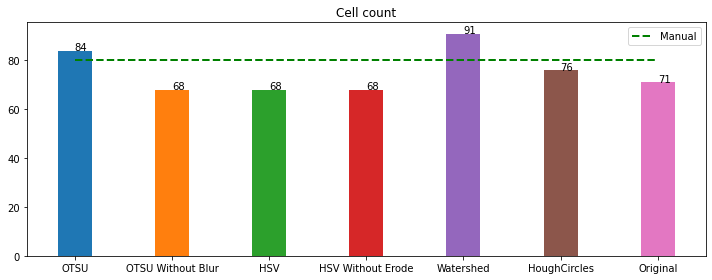

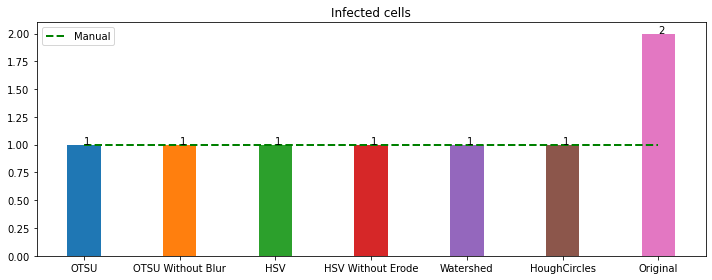

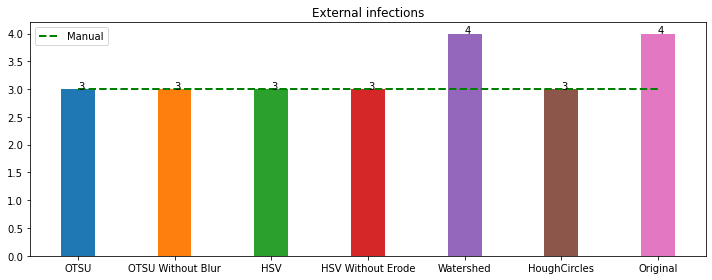

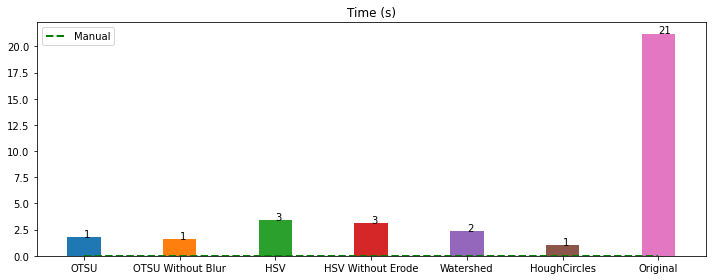

In [131]:

def graph(data,value):
    labels   = []
    
    x = np.arange(len(data)-1)  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(figsize=(10,4))

    pos = 0
    for method in data:
        if method["method"] == "Manual":
            plt.plot([method[value] for x in range(len(data)-1)], 
                         linestyle='dashed', 
                         linewidth=2, 
                         color='green',
                         label='Manual')
        else:
            labels.append(method['method'])
            rects1 = ax.bar(pos, method[value], width)
            ax.text(pos,method[value], int(method[value]))
            pos += 1

    
    if value == 'cells':
        ax.set_title('Cell count')
    if value == 'internal':
        ax.set_title('Infected cells')
    if value == 'external':
        ax.set_title('External infections')
    if value == 'time':
        ax.set_title('Time (s)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()
    
    
smp = 0
data = samples[smp]['data']
print(samples[smp]["name"])
graph(data,'cells')
graph(data,'internal')
graph(data,'external')
graph(data,'time')

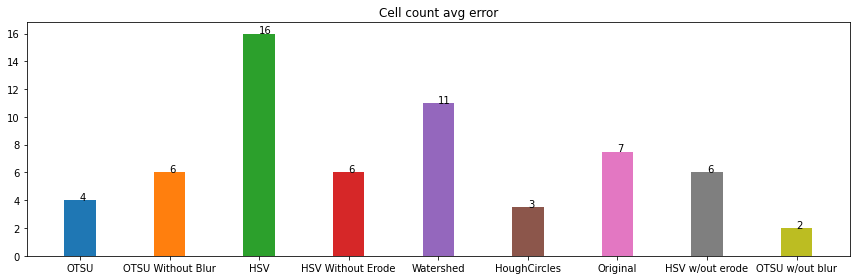

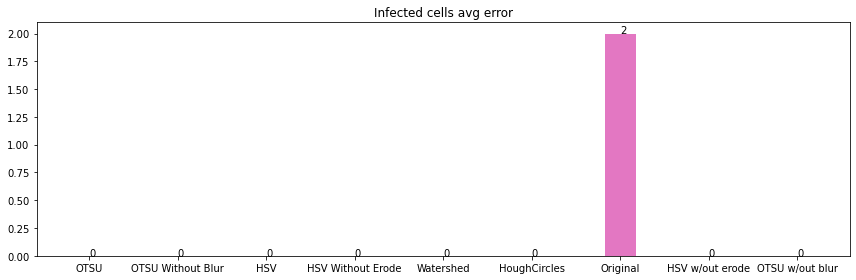

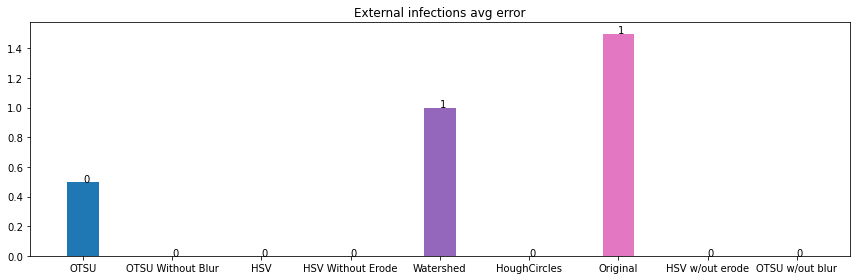

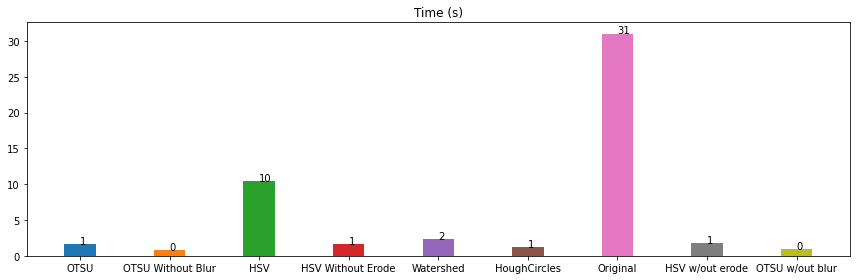

In [130]:
average = []
for smp in samples:
    data = smp['data']
    for method in data:
        if method['method'] == 'Manual':
            manual = method
            break
            
    for method in data:
        if method['method'] == 'Manual':
            continue
        
        found = False
        for avg in average:
            if avg['method'] == method['method']:
                found = True
                avg['cells']    += abs(manual['cells']-method['cells'])
                avg['internal'] += abs(manual['internal']-method['internal'])
                avg['external'] += abs(manual['external']-method['external'])
                avg['time']     += abs(manual['time']-method['time'])
        
        if found == False:
            average.append({"method"  : method['method'],
                            "cells"   : abs(manual['cells']-method['cells']),
                            "internal": abs(manual['internal']-method['internal']),
                            "external": abs(manual['external']-method['external']),
                            "time"    : abs(manual['time']-method['time'])})
            
for avg in average:
    avg['cells']    = avg['cells']/len(samples)
    avg['internal'] = avg['internal']/len(samples)
    avg['external'] = avg['external']/len(samples)
    avg['time']     = avg['time']/len(samples)

def errorGraph(data,value):
    labels   = []

    x = np.arange(len(data))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(figsize=(12,4))

    pos = 0
    for method in data:
        labels.append(method['method'])
        rects1 = ax.bar(pos, method[value], width)
        ax.text(pos,method[value], int(method[value]))
        pos += 1


    if value == 'cells':
        ax.set_title('Cell count avg error')
    if value == 'internal':
        ax.set_title('Infected cells avg error')
    if value == 'external':
        ax.set_title('External infections avg error')
    if value == 'time':
        ax.set_title('Time (s)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    fig.tight_layout()

    plt.show()
    
    
errorGraph(average,'cells')
errorGraph(average,'internal')
errorGraph(average,'external')
errorGraph(average,'time')